In [1]:
import numpy as np
import sqlalchemy
import matplotlib.pyplot as plt
import math
import seaborn as sns
from collections import Counter
import spectral_entropy
from scipy.spatial import distance
from scipy.cluster import hierarchy

In [2]:
from collections import Counter

In [3]:
database_address='../../data/database/bucketbase.db'

In [4]:
def execute_query(database_addres,query_string):
    '''
    
    '''
    engine=sqlalchemy.create_engine(f"sqlite:///{database_address}")
    connection=engine.connect()

    temp_cursor=connection.execute(
        query_string
    )

    temp_result=temp_cursor.fetchall()
    #print(temp_result)
    print(f'we have this many associated spectra {len(temp_result)}')
    #print(len(temp_result))
    
    connection.close()
    engine.dispose()
    #print(len(temp_result))

    if len(temp_result)==0:
        return -1
    elif len(temp_result)>1:
        print('here')
        return temp_result



In [5]:
def parse_one_ms_dial_spectrum(spectrum_text):
    '''
    takes an ms/ms spectrum as a string and returns a tuple of parallel lists?
    '''
    mz_int_pair_list=spectrum_text.split(' ')
    mz_list=[float(temp_pair.split(':')[0]) for temp_pair in mz_int_pair_list]
    intensity_list=[float(temp_pair.split(':')[1]) for temp_pair in mz_int_pair_list]
    
    return np.array([
        mz_list,
        intensity_list
    ])

In [6]:
def convert_np_spectrum_to_text(spectrum_array):
    '''
    takes an ms/ms spectrum in our numpy array format and converts it to string
    '''
    string_rep=[
        str(spectrum_array[0][i])+':'+str(spectrum_array[1][i]) for i in range(len(spectrum_array[0]))
    ]
    return ' '.join(string_rep)

In [7]:
def plot_some_head_to_tails(spectra,temp_axis,is_consensus=False):
    '''
    expects a list of spectra
    in the outer list, each spectrum is an element
    within each of those elements, the 0th element is an array of mz and teh 1th is array of intensities
    '''
    
    for spectrum in spectra:
        #print(spectrum)
        if is_consensus==False:
            temp_axis.stem(spectrum[0],spectrum[1])
        else:
            temp_axis.stem(spectrum[0],-1*spectrum[1])
    

In [8]:
def make_distance_matrix(spectra):
    #this is very slow. we should refactor this so that we use an intrinsically vectorized approach using scipy
    
    similarity_matrix=np.zeros(
        shape=(len(spectra),len(spectra))
    )
    
    #clean spectra
    #i think we should only put cleaned spectra into the database
    
    
    
    
    for i in range(len(spectra)):
        #if i%50==0:
        #    print(i)
        #for j in range(i,len(spectra)):
        for j in range(i,len(spectra)):
            #try:
            similarity_matrix[i][j]=spectral_entropy.similarity(
                spectra[i], spectra[j], 
                method='dot_product',ms2_da=0.1,
                need_clean_spectra=True,
                #need_normalize_result=False
            )
#             except IndexError:
#                 print(spectra[i])
#                 print(spectra[j])
#                 print('$$$$$$$$$$$$$$$$$$$$$$')
                
    #sns.heatmap(similarity_matrix)
    #plt.show()    
    #print(np.diagonal(similarity_matrix))
    #print('------------------------------------------')
    
    
    similarity_matrix=np.triu(similarity_matrix)
    similarity_matrix=similarity_matrix+similarity_matrix.T-np.diag(np.diag(similarity_matrix))
    
    
    
    ############DANGER##############
    #getting some error where 1 was being rep'd as 0.9999999
    #so i just manually set
    np.fill_diagonal(similarity_matrix,1)
    ###############################
    distance_matrix=1-similarity_matrix
    #make symmetric
    
    #sns.heatmap(distance_matrix)
    #plt.show()
    distance_matrix_flattened=distance.squareform(distance_matrix)
    #sns.heatmap(distance.squareform(distance_matrix_flattened))
    #plt.show()
    return similarity_matrix,distance_matrix_flattened
    ######similarity_matrix_flattened=distance.squareform(similarity_matrix)
    ######return similarity_matrix,similarity_matrix_flattened

In [9]:
def make_spectra_like_similarity_metric_expects(spectra):
    '''
    converts an array of parallel mz and intensity into pairs of mz,intensity
    '''
    output_list=list()
    for spectrum in spectra:
        #print(spectrum)
        output_list.append(np.column_stack(spectrum))
        #print(output_list)
        #hold=input('hold')
    return output_list

In [10]:
def get_list_of_bin_id_with_spectra():
    query='''SELECT bin_id,count(*)
    from annotations a
    where (spectrum is not null)
    group by bin_id
    '''
    spectrum_population_data=execute_query(database_address,query)
    #bin_ids=[element[0] for element in spectrum_population_data]
    #populations=[element[1] for element in spectrum_population_data]
    
    bin_id_sorted_by_pop=[
        x for x,_ in sorted(spectrum_population_data, key=lambda pair: pair[1],reverse=True)
    ]
    populations_sorted_by_pop=[
        x for _,x in sorted(spectrum_population_data, key=lambda pair: pair[1],reverse=True)
    ]
    #print(bin_id_sorted_by_pop)
    #print(populations_sorted_by_pop)
    return(bin_id_sorted_by_pop)

In [11]:
bin_ids_pop_desc=get_list_of_bin_id_with_spectra()

we have this many associated spectra 2946
here


In [12]:
def make_spectra_like_head_to_tails_expects(spectra):
    '''
    converts an array of parallel mz and intensity into pairs of mz,intensity
    '''
    output_list=list()
    for spectrum in spectra:
        #print(spectrum)
        output_list.append(np.stack(spectrum,axis=1))
        #print(output_list)
        #hold=input('hold')
    return output_list

In [13]:
def generate_bin_groups(bins, bin_space_tolerance):
    '''
    the idea is that we want to group together small clusters of bins (in case there)
    is a spread of mz. to do this, we iterate over all of the bins. for each bin,
    if it is very lcose to an already encountered bin, we group them. else, they are
    put in a new, separate bin.
    
    #an m/z can be assigned to multiple m/z groups
    '''
    #output_bin_dict=dict()
    #for temp_bin in bins:
    #bins.sort()
    #print(bin_space_tolerance)
    #print(bins)
    output_dict=dict()
    for temp_bin in bins:
        #for j in range(j,len(bins)):
        found_match=False
        for temp_key in output_dict.keys():
            for temp_value in output_dict[temp_key].copy():
                #print(temp_value)
                #print(temp_bin)
                #print(type(temp_value))
                #print(type(temp_bin))
                #print()
                if (abs(temp_bin-temp_value)<=bin_space_tolerance):
                    output_dict[temp_key].add(temp_bin)
                    found_match=True
        if found_match==False:
            output_dict[temp_bin]={temp_bin}
        #print(output_dict)
        
    
    for temp_key in output_dict.keys():
        for temp_value in output_dict[temp_key].copy():
            output_dict[temp_key].add(temp_value+1)
            output_dict[temp_key].add(temp_value-1)
    
    return output_dict

In [14]:
def find_bin_identities_with_x_percent_present(bin_identities,percent_present,spectrum_count):
    '''
    we want to find bins where the ion is found "at least 80 percent of the time"
    or whatever
    so, we calculate a minimum count from percent_present and spectrum_count
    then find the identity of each bin posseing that count
    '''
    minimum_count=math.floor(spectrum_count*percent_present)
    #print(minimum_count)
    #print(percent_present)
    #print(spectrum_count)
    my_counter=Counter(bin_identities)
    #print(my_counter)
    bins_meeting_count=[
        temp_bin for temp_bin in my_counter.keys() if my_counter[temp_bin]>minimum_count
    ]
    #print(bins_meeting_count)
    return bins_meeting_count

In [15]:
def generate_consensus_spectrum(spectra,ms2_tolerance_Da,percent_present,bin_space_tolerance):
    '''
    creates a consensus spectrum
    input:list of spectra, each spectrum expressed as 2xn np.array where 2,0 is mz and 2,1 is intensity
    1) get number of spectra
    2) concatenate each
    '''
    
    spectrum_count=len(spectra)
    
    all_mz_list=[spectrum[0] for spectrum in spectra]
    all_intensity_list=[spectrum[1] for spectrum in spectra]
    
    all_mz=np.concatenate(all_mz_list,dtype=object)
    all_intensity=np.concatenate(all_intensity_list,dtype=object)
    
    #print(all_mz)
    #print(all_intensity)
    
    bins=np.arange(all_mz.min(),all_mz.max()+ms2_tolerance_Da,ms2_tolerance_Da)
    
    #print(bins)
    bin_identities=np.digitize(
        all_mz,
        bins
    )
    
    #print(bin_identities)
    meaningful_bin_identities=find_bin_identities_with_x_percent_present(bin_identities,percent_present,spectrum_count)
    #print(meaningful_bin_identities)
    #print('-----------------')
    meaningful_bin_groupings=generate_bin_groups(meaningful_bin_identities,bin_space_tolerance)
    #print(all_mz.min())
    #print(all_mz.max())
    #print(meaningful_bin_identities)
    #print(meaningful_bin_groupings)
    average_mz_list,average_intensity_list=find_average_mz_and_intensity(
        bin_identities,
        all_mz,
        all_intensity,
        meaningful_bin_groupings
    )
    return np.array(
        [average_mz_list,average_intensity_list]
    )

In [16]:
def find_average_mz_and_intensity(
    bin_identities,
    all_mz,
    all_intensities,
    meaningful_bin_groupings
):
    '''
    the idea is that we 
    '''
    output_mz_list=list()
    output_intensity_list=list()

    for temp_key in meaningful_bin_groupings.keys():
        #we get a set of bin identities that we want
        temp_bins_of_interest=meaningful_bin_groupings[temp_key]
        #we map those bin identities to the indexes of bin_identities
        interesting_indexes=[
            i for i,element in enumerate(bin_identities) if (element in temp_bins_of_interest)
        ]
        interesting_mz=all_mz[interesting_indexes]
        interesting_intensities=all_intensities[interesting_indexes]
        #print(temp_bins_of_interest)
        #print(interesting_indexes)
        #print(interesting_mz)
        #print(interesting_intensities)
        output_mz_list.append(interesting_mz.mean())
        output_intensity_list.append(interesting_intensities.mean())
        

        #hold=input('hold')
    return output_mz_list,output_intensity_list


BIN ID 1
i is 0
we have this many associated spectra 216
here


/Users/parker.bremer/opt/anaconda3/envs/pre_db_pipeline/lib/python3.9/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/Users/parker.bremer/opt/anaconda3/envs/pre_db_pipeline/lib/python3.9/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


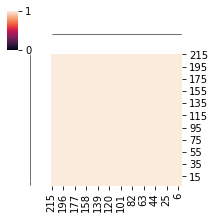

[1]
cluster counts ordered by population


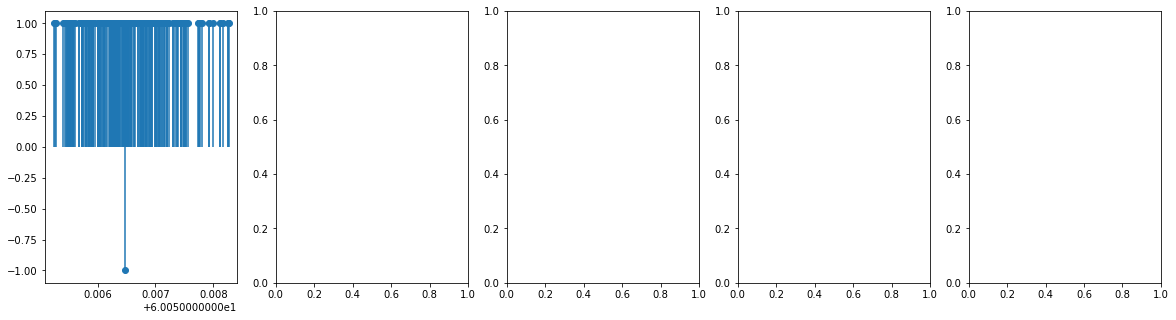

--------------------------------------------------
BIN ID 108
i is 1
we have this many associated spectra 216
here


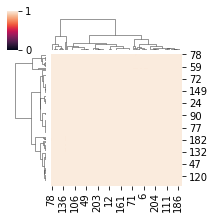

[1]
cluster counts ordered by population


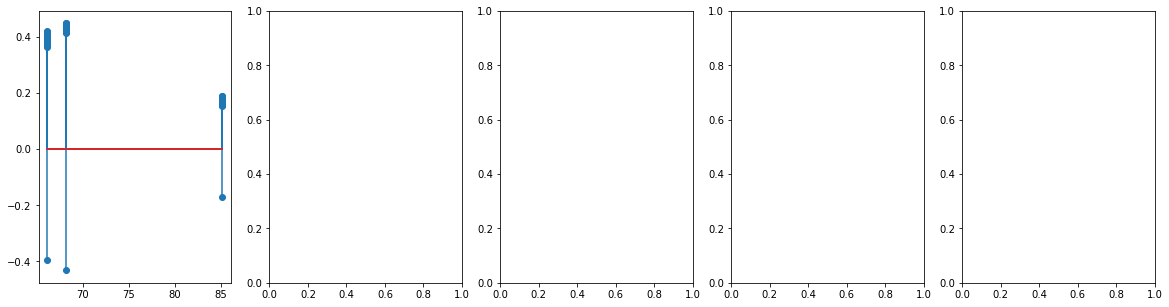

--------------------------------------------------
BIN ID 172
i is 2
we have this many associated spectra 216
here


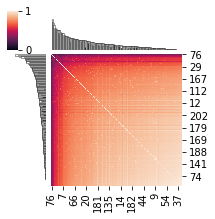

[10, 6, 5, 9, 1, 7, 55, 43, 25, 50, 39, 2, 13, 45, 21, 3, 40, 42, 18, 8, 17, 47, 14, 12, 34, 11, 51, 26, 29, 57, 20, 58, 44, 22, 23, 53, 28, 30, 41, 54, 33, 32, 46, 15, 19, 52, 37, 16, 31, 56, 48, 24, 38, 36, 4, 35, 49, 27]


KeyboardInterrupt: Interrupted by user

In [17]:
starting_num=0
ending_num=30
clusters_to_include=5



for i,temp_bin in enumerate(bin_ids_pop_desc):

    #print(temp_bin)
    if i<starting_num or i>ending_num:#i<80 or i>100: #or i<2:
        continue
    #if i<500 or i>511:
    #    continue
    print(f'BIN ID {temp_bin}')
    print(f'i is {i}')
    get_spectrum_sample_query=f'''
    select spectrum from runs r
    inner join annotations a
    on r.run_id=a.run_id
    where (run_type="Sample") and (bin_id={temp_bin}) and (spectrum is not null)
    '''
    
    input_spectra_list=execute_query(database_address,get_spectrum_sample_query)

    input_spectra_list=[temp_tup[0] for temp_tup in input_spectra_list]

    all_spectrum_list=[
        parse_one_ms_dial_spectrum(temp_spectrum) for temp_spectrum in input_spectra_list
    ]
    all_spectrum_list_yuanyue=make_spectra_like_similarity_metric_expects(all_spectrum_list)
        
    #####Put routine like "denoising" here if we desire#####
    #yuanyues code denoises alreayd....
    
    #generate the similarity matrix
    similarity_matrix,distance_matrix_flattened=make_distance_matrix(all_spectrum_list_yuanyue)
    
    #generate the linkage matrix
    row_linkage=hierarchy.linkage(
        distance_matrix_flattened,method='average'
    )
    
    #print(row_linkage)
    #hold=input('hold')
    #generate the linkage matrix
    column_linkage=row_linkage
    
    #make the heatmap
    sns.clustermap(
        similarity_matrix,
        row_linkage=row_linkage,
        col_linkage=column_linkage,
        vmin=0,
        vmax=1,
        figsize=(3,3),
    )
    plt.show()
    

    cluster_identities=hierarchy.fcluster(
        Z=row_linkage,
        t=0.2,
        criterion='distance',
    )
    #print(cluster_identities)
    
    cluster_counts=Counter(cluster_identities)
    cluster_counts=[(key,cluster_counts[key]) for key in cluster_counts]
    cluster_counts_ordered_by_population=[
        x for x,_ in sorted(cluster_counts, key=lambda pair: pair[1],reverse=True)
    ]
    print(cluster_counts_ordered_by_population)
    hold=input('cluster counts ordered by population')
    
    #print(cluster_counts_ordered_by_population)
    #     hierarchy.dendrogram(
    #         Z=row_linkage,
    #         orientation='top'
    #     )
    #plt.show()
    fix,ax=plt.subplots(
        #nrows=(ending_num-starting_num)+1,
        nrows=1,
        ncols=clusters_to_include,
        figsize=(20,5)
    )
    for j,temp_cluster_identity in enumerate(cluster_counts_ordered_by_population):
        
        if j >=5:
            continue
        
        temp_spectra_for_consensus=list()
        for k,temp_assignment in enumerate(cluster_identities):
            if temp_assignment==temp_cluster_identity:
                temp_spectra_for_consensus.append(
                    all_spectrum_list[k]
                )
        
        temp_spectra_for_consensus_yuanyue=make_spectra_like_similarity_metric_expects(temp_spectra_for_consensus)
        for k in range(len(temp_spectra_for_consensus)):
            temp_spectra_for_consensus_yuanyue[k]=spectral_entropy.tools.clean_spectrum(
                temp_spectra_for_consensus_yuanyue[k],
                noise_removal=0.05,
                ms2_da=0.03
            )
        temp_spectra_for_consensus=make_spectra_like_head_to_tails_expects(
            temp_spectra_for_consensus_yuanyue
        )
        #print(len(temp_spectra_for_consensus))
        #print(i)
        #print(temp_spectra_for_consensus)
        #print('*********************************************')
        plot_some_head_to_tails(temp_spectra_for_consensus,ax[j])
        temp_consensus_spectrum=generate_consensus_spectrum(
            temp_spectra_for_consensus,
            0.015,
            0.3,
            3
        )
        #print(temp_consensus_spectrum)
        #fig_2,ax_2=plt.subplots(
        #    #nrows=(ending_num-starting_num)+1,
        #    nrows=1,
        # #   ncols=1,
        #    figsize=(5,5)
        #)
        plot_some_head_to_tails([temp_consensus_spectrum],ax[j],is_consensus=True)
        
    plt.show()
    print('--------------------------------------------------')